## 一、简介
对抗攻击：攻击者就会通过设计一种有针对性的数值型向量从而让机器学习模型做出误判，这便被称为对抗性攻击，简单来说就是研究如何生成能使网络出错的样本。

根据条件不同，对抗攻击主要可分为：
- 黑盒攻击与白盒攻击（攻击环境）
黑箱攻击向目标模型提供了不了解该模型而生成的对抗样本(在测试期间)；白箱攻击假定（对抗者）完全了解目标模型，包括其参数值、体系结构、训练方法，在某些情况下还包括其训练数据。
- 有目标攻击和无目标攻击（攻击的目标）
无目标攻击指攻击只要使得网络出错即可，目标攻击则不仅要使得网络出错，而且要指定错误的情况
- 基于梯度的攻击、基于优化的攻击、基于决策面的攻击或者其他（攻击实现方式）
 
 对抗样本示意图：
 
 ![](https://ai-studio-static-online.cdn.bcebos.com/5dd1e9d487af4db792fad963f40c8d6de75eb5a4feba48378c5b84d484bf3e6a)
 
 值得注意的是，深度学习目前比较缺乏可解释性，大多数情况下深度学习模型作为黑盒适用，但在许多关键领域，例如自动驾驶、金融风险评估和医疗诊断等，人工智能系统的可靠性和安全性是至关重要的。
 
 通过研究对抗样本，我们可以发现和修复模型的漏洞，提高系统的鲁棒性和可信度，从而避免潜在的错误和风险。
 
 通过理解对抗样本的生成原理和攻击机制，我们可以开发更加有效的防御机制和对抗性训练方法，以应对不断增长的安全挑战。
 
 这对于保护个人隐私、防止网络欺诈和数据泄露等具有重要意义的问题具有实际应用价值。
 
 关于对抗样本更详细的入门介绍：https://blog.csdn.net/weixin_45521594/article/details/104629732。有兴趣可以看一下。

# **四种攻击算法的实现**

In [ ]:
!unzip -oq /home/aistudio/data/data83370/data.zip -d /home/aistudio/work/

In [ ]:
!tar -xf /home/aistudio/data/data68594/ILSVRC2012_img_val.tar -C/home/aistudio/work/data2

In [1]:
import glob
import os
paths=sorted(glob.glob('/home/aistudio/work/data2/*.JPEG'))
print(len(paths))
for i,path in enumerate(paths):
    if i>1000:
        os.remove(path)


1001


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from paddle.vision.transforms import Compose,Resize,Transpose,Normalize
import cv2
import os
from PIL import Image
from paddle.vision.models import vgg16,resnet50
import pandas as pd
import glob
import paddle
from paddle.nn import CrossEntropyLoss
from paddle.nn.functional import nll_loss
import math
from tqdm import tqdm

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


In [3]:
model=vgg16(pretrained=True)

W0618 22:54:40.269593    98 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W0618 22:54:40.276091    98 device_context.cc:372] device: 0, cuDNN Version: 7.6.
2024-06-18 22:54:46,114 - INFO - unique_endpoints {''}
2024-06-18 22:54:46,116 - INFO - Downloading vgg16.pdparams from https://paddle-hapi.bj.bcebos.com/models/vgg16.pdparams
100%|██████████| 817517/817517 [00:12<00:00, 67042.87it/s]
2024-06-18 22:54:58,489 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/vgg16.pdparams md5 checking...


In [4]:
def transform_img(img):
    mean=[127.5,127.5,127.5]
    std=[127.5,127.5,127.5]
    transform=Compose([Resize(size=224),Transpose(),Normalize(mean=mean,std=std)])
    img=transform(img)
    return img

In [5]:
def data_loader(batch_size):
    img_dirs=sorted(glob.glob("/home/aistudio/work/data/images/*.png"))
    def reader():
        batch_imgs=[]
        batch_labels=[]
        for i,img_dir in enumerate(img_dirs):
            #读取图像
            img=Image.open(img_dir)
            img=np.array(img).astype(np.float32)
            img=transform_img(img)
            #读取标签
            label=pd.read_csv('work/data/labels.csv')
            label=(label['TrueLabel'][i])
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs)==batch_size:
                imgs_array=np.array(batch_imgs).astype(np.float32)
                labels_array=np.array(batch_labels).astype(np.int64)
                yield imgs_array,labels_array
                batch_imgs=[]
                batch_labels=[]
        if len(batch_imgs)>0:
            imgs_array=np.array(batch_imgs).astype(np.float32)
            labels_array=np.array(batch_labels).astype(np.int64)
            yield imgs_array,labels_array
    return reader



In [17]:
def data_loader2(batch_size):
    img_dirs=sorted(glob.glob("work/data2/*.JPEG"))
    def reader():
        batch_imgs=[]
        batch_labels=[]
        f=open('data/data68594/val_list.txt','r')
        labels=f.readlines()
        for i,img_dir in enumerate(img_dirs):
            #读取图像
            img=Image.open(img_dir)
            img=np.array(img).astype(np.float32)
            img=transform_img(img)
            #读取标签
            label=eval(labels[i].strip('\n').split(' ')[1])
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs)==batch_size:
                imgs_array=np.array(batch_imgs).astype(np.float32)
                labels_array=np.array(batch_labels).astype(np.int64)
                yield imgs_array,labels_array
                batch_imgs=[]
                batch_labels=[]
        if len(batch_imgs)>0:
            imgs_array=np.array(batch_imgs).astype(np.float32)
            labels_array=np.array(batch_labels).astype(np.int64)
            yield imgs_array,labels_array
    return reader



## **FGSM**
利用对抗样本的线性解释提出了一个快速产生对抗样本的方式，也即Fast Gradient Sign Method(FGSM)方法。假定模型参数值为θ，输入为x，标签为y，则模型的损失函数为J(θ,x,y)。FGSM方法将保证无穷范数限制下，添加的扰动值为η=εsign(∇xJ(θ,x,y))。<br>
![](https://ai-studio-static-online.cdn.bcebos.com/7c25f095ba8746c3b2dd2e3ad83250bdbd4ed2870da544e6b2134db851b5ef08)

In [7]:
class FGSM():
    def __init__(self, model, criterion, data, eps,num_size):
        self.model = model
        self.criterion = criterion
        self.data = data
        self.epsilon = eps/127.5  # 扰动
        self.num_size=num_size
    def attack(self):
        perturbed_img=[]
        perturbed_label=[]
        org_img=[]
        org_label=[]
        wrong=0
        right=0
        success=0
        for i,(img,label) in enumerate(tqdm(self.data(), total=self.num_size)):
            if i==self.num_size:
                break
            tensor_img = paddle.to_tensor(img)
            tensor_label=paddle.to_tensor(label)
            tensor_img.stop_gradient = False
            predict = self.model(tensor_img)
            pred=predict.argmax(axis=1)
            if pred== tensor_label:#如果被正确分类则执行攻击
                right+=1
                loss = self.criterion(predict, tensor_label)
                loss.backward()
                grad = paddle.to_tensor(tensor_img.grad)
                grad = paddle.sign(grad)   # 对每个元素进行正负判断
                adv_img = tensor_img + self.epsilon * grad
                #攻击完成之后再次预测
                predict = self.model(adv_img)
                pred=predict.argmax(axis=1)
                if pred!=tensor_label:
                    success+=1
                    #将攻击后的图片保存下来
                    adv_img=paddle.transpose(adv_img,perm=[0,2,3,1]).numpy()
                    tensor_img=paddle.transpose(tensor_img,perm=[0,2,3,1]).numpy()

                    adv_img=np.squeeze(adv_img)
                    tensor_img=np.squeeze(tensor_img)

                    # 逆归一化的过程则是将归一化后的像素值恢复到原始范围[0, 255]
                    adv_img=adv_img*127.5+127.5     
                    tensor_img=tensor_img*127.5+127.5

                    adv_img=adv_img.astype(np.int64)
                    perturbed_img.append(adv_img)

                    tensor_img=tensor_img.astype(np.int64)
                    org_img.append(tensor_img)
                    
                    org_label.append(tensor_label.numpy())
                    perturbed_label.append(pred.numpy())
            else:
                wrong+=1
                continue
        if right:        
            succ_rate=success/right  # 攻击成功率
        else :
            print("全都预测错误")
            return 
        print(right)
        return succ_rate,perturbed_img,org_img,perturbed_label,org_label

In [8]:
attack=FGSM(model,CrossEntropyLoss(),data_loader2(batch_size=1),eps=4,num_size=1000)
acc,perturbed_img,org_img,perturbed_label,org_label=attack.attack()
print(acc)

100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s]

625
0.7408


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
2024-06-18 22:56:26,392 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-06-18 22:56:26,416 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-06-18 22:56:26,437 - WARNING - Clipping input data to the valid range for imshow wit

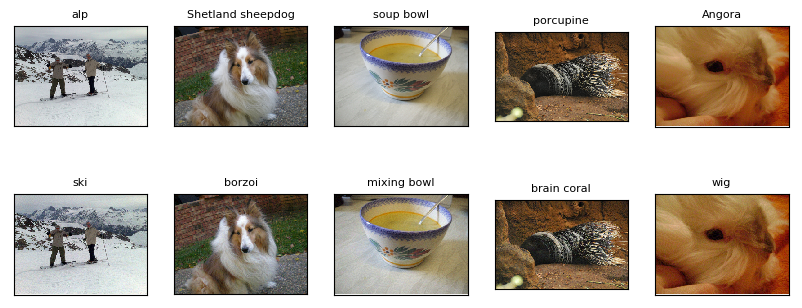

In [9]:
category=pd.read_csv('work/data/categories.csv')
plt.figure(figsize=(10,4),dpi=100)
for i in range (5):
    o_img=org_img[i]
    o_label=org_label[i][0]
    p_img=perturbed_img[i]
    p_label=perturbed_label[i][0]
    o_label=category['CategoryName'][o_label].split(', ')[0]
    p_label=category['CategoryName'][p_label].split(', ')[0]
    plt.subplot(2,5,i+1)
    title=o_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o_img)
    plt.subplot(2,5,6+i)
    title=p_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(p_img)

In [10]:
(org_img[0]-perturbed_img[0]==4).sum()

99870

# **BIM**
Goodfellow基于之前的FGSM攻击方法做出了一部分改进，作者鉴于之前的FGSM的成功率并不高，提出了以迭代的方式来进行攻击，也就是Basic Iterative Methods(BIM)，是FGSM方法的进阶，因此也被称为Iterative FGSM(I-FGSM).算法流程如下：<br><br>
![](BIM流程.png)<br><br>
损失函数一般为交叉熵损失。<br><br>



In [11]:
class BIM():
    def __init__(self, model, criterion, data, eps,num_iters,num_size):
        self.model = model
        self.criterion = criterion
        self.data = data
        self.epsilon = eps/127.5   
        self.alpha=self.epsilon/num_iters   
        self.num_size=num_size
        # self.num_iters = math.ceil(min(eps + 4, 1.25 * eps))
        self.num_iters=num_iters
    def attack(self):
        perturbed_img=[]
        perturbed_label=[]
        org_img=[]
        org_label=[]
        wrong=0
        right=0
        success=0
        for i,(img,label) in enumerate(tqdm(self.data(), total=self.num_size)):
            if i==self.num_size:
                break
            tensor_img = paddle.to_tensor(img)
            adv_img=paddle.to_tensor(img)
            tensor_label=paddle.to_tensor(label)
            tensor_img.stop_gradient = False
            tensor_label.stop_gradient = False
            predict = self.model(tensor_img)
            pred=predict.argmax(axis=1)
            if pred== tensor_label:#如果被正确分类则执行攻击
                right+=1
                # Add code
                for _ in range(self.num_iters):
                    adv_img.stop_gradient = False
                    predict = self.model(adv_img)
                    loss = self.criterion(predict, tensor_label)

                    # 清除上一次迭代的梯度
                    self.model.clear_gradients()
                    
                    # loss.backward(retain_graph=True)
                    loss.backward()
                    
                    grad = paddle.to_tensor(adv_img.grad)
                    # print(grad)
                    adv_img = adv_img + self.alpha * paddle.sign(grad)
                    
                    # Clipping the perturbations to ensure they are within the allowable range
                    # adv_img = paddle.clip(adv_img, tensor_img - self.epsilon, tensor_img + self.epsilon)
                    adv_img = paddle.clip(adv_img, -1, 1)  # Ensure the adversarial image is in [0, 1] range
                    adv_img = adv_img.detach()

                # 攻击完成之后再次预测
                predict = self.model(adv_img)
                pred = predict.argmax(axis=1)
                
                if pred != tensor_label:
                    success += 1
                    # 将攻击后的图片保存下来
                    adv_img = paddle.transpose(adv_img, perm=[0, 2, 3, 1]).numpy()
                    tensor_img = paddle.transpose(tensor_img, perm=[0, 2, 3, 1]).numpy()

                    adv_img = np.squeeze(adv_img)
                    tensor_img = np.squeeze(tensor_img)

                    # 逆归一化
                    adv_img = adv_img * 127.5 + 127.5
                    tensor_img = tensor_img * 127.5 + 127.5

                    adv_img = adv_img.astype(np.int64)
                    perturbed_img.append(adv_img)

                    tensor_img = tensor_img.astype(np.int64)
                    org_img.append(tensor_img)

                    org_label.append(tensor_label.numpy())
                    perturbed_label.append(pred.numpy())

            else:
                wrong+=1
                continue
        if right:        
            succ_rate=success/right
        else :
            print("全都预测错误")
            return 
        # print(right)
        return succ_rate,perturbed_img,org_img,perturbed_label,org_label

In [12]:
attack=BIM(model,CrossEntropyLoss(),data_loader2(batch_size=1),eps=4,num_size=1000,num_iters=5)
acc,perturbed_img,org_img,perturbed_label,org_label=attack.attack()
print(acc)
print(len(perturbed_img))

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]

0.9004739336492891
570


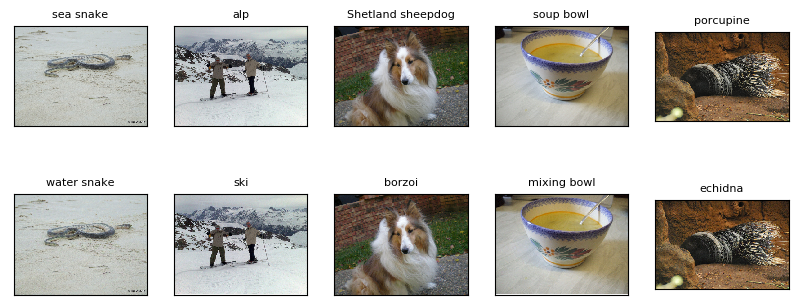

In [13]:
category=pd.read_csv('work/data/categories.csv')
plt.figure(figsize=(10,4),dpi=100)
for i in range (5):
    o_img=org_img[i]
    o_label=org_label[i][0]
    p_img=perturbed_img[i]
    p_label=perturbed_label[i][0]
    o_label=category['CategoryName'][o_label].split(', ')[0]
    p_label=category['CategoryName'][p_label].split(', ')[0]
    plt.subplot(2,5,i+1)
    title=o_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o_img)
    plt.subplot(2,5,6+i)
    title=p_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(p_img)

In [14]:
(org_img[0]-perturbed_img[0]==-1).sum()

42985

# **PGD**
在BIM基础上，PGD增加了一层随机化处理，即在先给干净样本加上随机扰动（代码中要求自己测试出比较好的随机扰动并采用），再执行BIM中更新步骤。<br><br>


In [15]:
# 依据BIM补充PGD攻击代码
# Add code
def data_loader2(batch_size):
    img_dirs=sorted(glob.glob("work/data2/*.JPEG"))
    def reader():
        batch_imgs=[]
        batch_labels=[]
        f=open('data/data68594/val_list.txt','r')
        labels=f.readlines()
        for i,img_dir in enumerate(img_dirs):
            #读取图像
            img=Image.open(img_dir)
            img=np.array(img).astype(np.float32)
            img=transform_img(img)

            # 添加均匀分布的随机扰动
            noise = np.random.uniform(low=-4/127.5, high=4/127.5, size=img.shape)
            img = img + noise
            img = np.clip(img, -1, 1)  # 保证图像在[-1, 1]范围内

            #读取标签
            label=eval(labels[i].strip('\n').split(' ')[1])
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs)==batch_size:
                imgs_array=np.array(batch_imgs).astype(np.float32)
                labels_array=np.array(batch_labels).astype(np.int64)
                yield imgs_array,labels_array
                batch_imgs=[]
                batch_labels=[]
        if len(batch_imgs)>0:
            imgs_array=np.array(batch_imgs).astype(np.float32)
            labels_array=np.array(batch_labels).astype(np.int64)
            yield imgs_array,labels_array
    return reader


# Evaluate
attack=BIM(model,CrossEntropyLoss(),data_loader2(batch_size=1),eps=4,num_size=1000,num_iters=5)
acc,perturbed_img,org_img,perturbed_label,org_label=attack.attack()
print(acc)
print(len(perturbed_img))

100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]

0.9165354330708662
582


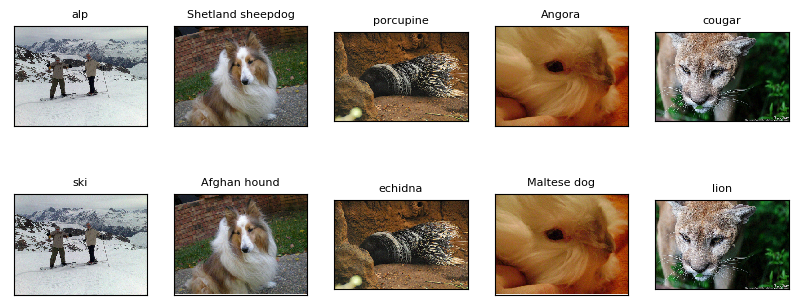

In [16]:
category=pd.read_csv('work/data/categories.csv')
plt.figure(figsize=(10,4),dpi=100)
for i in range (5):
    o_img=org_img[i]
    o_label=org_label[i][0]
    p_img=perturbed_img[i]
    p_label=perturbed_label[i][0]
    o_label=category['CategoryName'][o_label].split(', ')[0]
    p_label=category['CategoryName'][p_label].split(', ')[0]
    plt.subplot(2,5,i+1)
    title=o_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o_img)
    plt.subplot(2,5,6+i)
    title=p_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(p_img)

# **MIFGSM**
MIFGSM（Momentum Iterative Fast Gradient Sign Method）是一种用于生成对抗样本的攻击方法。它是对快速梯度符号攻击（FGSM）的改进，通过引入动量来增强攻击的效果和稳定性。

MIFGSM攻击方法在每次迭代中利用梯度信息来更新对抗样本。与FGSM只使用一次梯度更新相比，MIFGSM通过多次迭代的方式不断更新对抗样本，从而更好地探索梯度空间。每次迭代中，MIFGSM通过计算当前对抗样本的梯度，并将其与之前的动量进行结合，来生成下一个对抗扰动，这样的操作使得攻击更加稳定。

MIFGSM方法的引入动量的特点使得攻击在优化过程中能够更好地跳出局部最优解，并且对抗样本的扰动也更具鲁棒性。同时，MIFGSM方法也具备高效性，因为它只需要进行少量的迭代就可以生成有效的对抗样本。

原文链接：https://arxiv.org/abs/1710.06081

算法如下：

![](MIFGSM.png)

In [18]:
class MIFGSM():
    def __init__(self, model, criterion, data, eps,num_iters,decay_factor=1,num_size=200):
        self.model = model
        self.criterion = criterion
        self.data = data
        self.epsilon = eps/127.5   # 扰动大小
        self.alpha=self.epsilon/num_iters   # 迭代步长
        self.num_size=num_size
        self.num_iters=num_iters
        self.decay_factor=decay_factor
    def attack(self):
        perturbed_img=[]
        perturbed_label=[]
        org_img=[]
        org_label=[]
        wrong=0
        right=0
        success=0
        for i,(img,label) in enumerate(tqdm(self.data(), total=self.num_size)):
            if i==self.num_size:
                break
            tensor_img = paddle.to_tensor(img)
            adv_img=paddle.to_tensor(img)
            tensor_label=paddle.to_tensor(label)
            predict = self.model(tensor_img)
            pred=predict.argmax(axis=1)
            if pred== tensor_label:#如果被正确分类则执行攻击
                right+=1
                # Add code
                g = paddle.zeros_like(tensor_img)
                for _ in range(self.num_iters):
                    adv_img.stop_gradient = False
                    predict_adv = self.model(adv_img)
                    loss = self.criterion(predict_adv, tensor_label)

                    # 清除上一次迭代的梯度
                    self.model.clear_gradients()
                    loss.backward()

                    grad = paddle.to_tensor(adv_img.grad)
                    g = self.decay_factor * g + grad.sign()
                    adv_img = adv_img + self.alpha * g
                    adv_img = paddle.clip(adv_img, -1, 1)
                    # adv_img = paddle.clip(adv_img, tensor_img - self.epsilon, tensor_img + self.epsilon)
                    adv_img = adv_img.detach()


                # 攻击完成之后再次预测
                predict = self.model(adv_img)
                pred = predict.argmax(axis=1)
                
                if pred != tensor_label:
                    success += 1
                    # 将攻击后的图片保存下来
                    adv_img = paddle.transpose(adv_img, perm=[0, 2, 3, 1]).numpy()
                    tensor_img = paddle.transpose(tensor_img, perm=[0, 2, 3, 1]).numpy()

                    adv_img = np.squeeze(adv_img)
                    tensor_img = np.squeeze(tensor_img)

                    # 逆归一化
                    adv_img = adv_img * 127.5 + 127.5
                    tensor_img = tensor_img * 127.5 + 127.5

                    adv_img = adv_img.astype(np.int64)
                    perturbed_img.append(adv_img)

                    tensor_img = tensor_img.astype(np.int64)
                    org_img.append(tensor_img)

                    org_label.append(tensor_label.numpy())
                    perturbed_label.append(pred.numpy())


            else:
                wrong+=1
                continue
        if right:        
            succ_rate=success/right
        else :
            print("全都预测错误")
            return 
        # print(right)
        return succ_rate,perturbed_img,org_img,perturbed_label,org_label

In [19]:
attack=MIFGSM(model,CrossEntropyLoss(),data_loader2(batch_size=1),eps=4,num_iters=5,num_size=1000,decay_factor=1)
acc,perturbed_img,org_img,perturbed_label,org_label=attack.attack()
print(acc)
# print(len(perturbed_img))

100%|██████████| 1000/1000 [02:15<00:00,  7.39it/s]

0.9235668789808917


In [20]:
(org_img[0]-perturbed_img[0]==1).sum()

12337

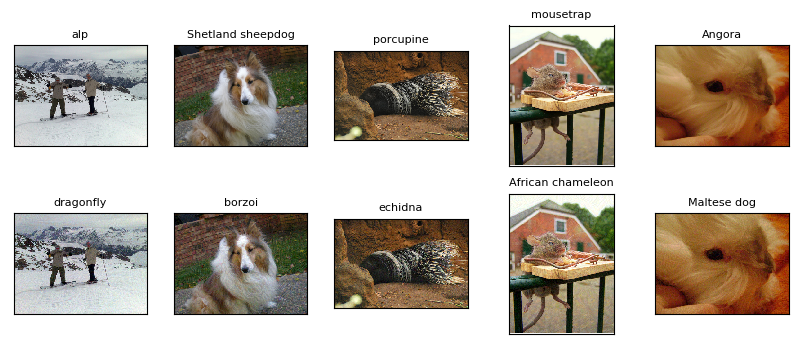

In [21]:
category=pd.read_csv('work/data/categories.csv')
plt.figure(figsize=(10,4),dpi=100) 
for i in range (5):
    o_img=org_img[i]
    o_label=org_label[i][0]
    p_img=perturbed_img[i]
    p_label=perturbed_label[i][0]
    o_label=category['CategoryName'][o_label].split(', ')[0]
    p_label=category['CategoryName'][p_label].split(', ')[0]
    plt.subplot(2,5,i+1)
    title=o_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(o_img)
    plt.subplot(2,5,6+i)
    title=p_label
    plt.title(title,fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(p_img)